# Statistics for National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** 

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import gdal
import pandas as pd
import math
import scipy.ndimage
from skimage import measure
import random
import os
import sys

## Generate virtual rasters for easy visualisation

In [3]:
# # Create virtual rasters
os.system('gdalbuildvrt output_data/geotiff/nidem/NIDEM.vrt output_data/geotiff/nidem/NIDEM_*.tif')
os.system('gdalbuildvrt output_data/geotiff/nidem_unfiltered/NIDEM_unfiltered.vrt output_data/geotiff/nidem_unfiltered/NIDEM_unfiltered*.tif')
os.system('gdalbuildvrt output_data/geotiff/nidem_mask/NIDEM_mask.vrt output_data/geotiff/nidem_mask/NIDEM_mask*.tif')
os.system('gdalbuildvrt output_data/geotiff/nidem_uncertainty/NIDEM_uncertainty.vrt output_data/geotiff/nidem_uncertainty/NIDEM_uncertainty*.tif')
# # os.system('gdalbuildvrt ITEM_rel.vrt /g/data2/v10/ITEM/rel_products/ITEM_REL*.tif')

# Build pyramids for DEMs
os.system('gdaladdo -ro --config COMPRESS_OVERVIEW DEFLATE -r AVERAGE -ro output_data/geotiff/nidem/NIDEM.vrt 2 4 8 16 32 64')
os.system('gdaladdo -ro --config COMPRESS_OVERVIEW DEFLATE -r AVERAGE -ro output_data/geotiff/nidem_unfiltered/NIDEM_unfiltered.vrt 2 4 8 16 32 64')
os.system('gdaladdo -ro --config COMPRESS_OVERVIEW DEFLATE -r AVERAGE -ro output_data/geotiff/nidem_uncertainty/NIDEM_uncertainty.vrt 2 4 8 16 32 64')

0

## Export NIDEM elevations and ranges per polygon

In [37]:
out_list = list()

# List of polygons
nidem_dems = sorted(glob.glob("output_data/geotiff/dem/*.tif"))

# For each NIDEM DEM, export .csv of min, max elevations and range
for i, dem in enumerate(nidem_dems):
    
    # open raster and choose band to find min, max
    print('Importing {}'.format(dem))
    gtif = gdal.Open(dem)
    srcband = gtif.GetRasterBand(1)   
    nidem_array = srcband.ReadAsArray()   

    # Get raster statistics
    stats = srcband.GetStatistics(True, True)    
    
    # Get attributes
    polygon = dem.split("_")[-1][:-4]
    elev_min = stats[0]
    elev_max = stats[1]
    elev_range = elev_max - elev_min
    intertidal_pixels = np.count_nonzero(nidem_array != -9999.)
    intertidal_km2 = intertidal_pixels * (25 * 25) / (1000 * 1000)
    
    if elev_range > 0:
    
        # Compute slope
        slope_ds = gdal.DEMProcessing(destName='scratch/nidem_slope.tif', 
                                      srcDS=dem, 
                                      processing = 'slope',
                                      scale = 1)
        slope_array = slope_ds.GetRasterBand(1).ReadAsArray()  
        slope_array[slope_array == -9999.] = np.nan
        slope_mean = np.nanmean(slope_array)
        slope_median = np.nanmedian(slope_array)
        
        # Compute slope
        roughness_ds = gdal.DEMProcessing(destName='scratch/nidem_roughness.tif', 
                                      srcDS=dem, 
                                      processing = 'roughness',
                                      scale = 1)
        roughness_array = roughness_ds.GetRasterBand(1).ReadAsArray()  
        roughness_array[roughness_array == -9999.] = np.nan
        roughness_mean = np.nanmean(roughness_array)
    
    else:
        
        slope_mean, slope_median, roughness_mean = "", "", ""
    
    # Append to list
    out_list.append([polygon, elev_min, elev_max, elev_range, slope_mean, slope_median, roughness_mean,
                     intertidal_pixels, intertidal_km2])    
    
    # Close datasets
    gtif = None
    slope_ds = None
    roughness_ds = None

# Combine values into pandas dataframe and export to .csv
polygon_elev_df = pd.DataFrame(out_list, columns=['ID', 'elev_min', 'elev_max', 'elev_range', 
                                                  'slope_mean', 'slope_median', 'roughness_mean',
                                                  'intertidal_pixels', 'intertidal_km2'])
polygon_elev_df.to_csv("NIDEM_polygon_stats.csv", index=False)

Importing output_data/geotiff/dem/NIDEM_dem_1.tif
Importing output_data/geotiff/dem/NIDEM_dem_10.tif
Importing output_data/geotiff/dem/NIDEM_dem_100.tif
Importing output_data/geotiff/dem/NIDEM_dem_101.tif
Importing output_data/geotiff/dem/NIDEM_dem_102.tif
Importing output_data/geotiff/dem/NIDEM_dem_103.tif
Importing output_data/geotiff/dem/NIDEM_dem_104.tif
Importing output_data/geotiff/dem/NIDEM_dem_105.tif
Importing output_data/geotiff/dem/NIDEM_dem_106.tif
Importing output_data/geotiff/dem/NIDEM_dem_107.tif
Importing output_data/geotiff/dem/NIDEM_dem_108.tif
Importing output_data/geotiff/dem/NIDEM_dem_109.tif
Importing output_data/geotiff/dem/NIDEM_dem_11.tif
Importing output_data/geotiff/dem/NIDEM_dem_110.tif
Importing output_data/geotiff/dem/NIDEM_dem_111.tif
Importing output_data/geotiff/dem/NIDEM_dem_112.tif
Importing output_data/geotiff/dem/NIDEM_dem_113.tif
Importing output_data/geotiff/dem/NIDEM_dem_114.tif
Importing output_data/geotiff/dem/NIDEM_dem_115.tif
Importing output

In [36]:
# Sum of area
print('Total area = {:0.2f}'.format(polygon_elev_df['intertidal_km2'].sum()))
print('Min elevation = {:0.2f}'.format(polygon_elev_df['elev_min'].min()))
print('Max elevation = {:0.2f}'.format(polygon_elev_df['elev_max'].max()))
print('Max range = {:0.2f}'.format(polygon_elev_df['elev_range'].max()))

Total area = 15387.34
Min elevation = -5.57
Max elevation = 3.41
Max range = 7.69


257.075625

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


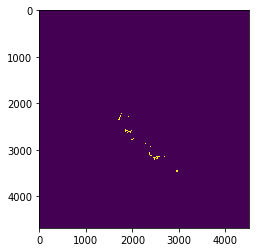

In [440]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/rt1527/dea-notebooks/algorithms'))
import SpatialTools 

def gaussian_curvature(Z):
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K

curv_array = gaussian_curvature(nidem_array / 1000)
np.nanmin(curv_array)
plt.imshow(curv_array > 0)
plt.imshow(curv_array < 0)

gtif = gdal.Open(dem)
prj = gtif.GetProjection()
geotrans = gtif.GetGeoTransform()


SpatialTools.array_to_geotiff(fname = "scratch/test_curv2.tif", 
                              data = curv_array, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = np.nan,
                              dtype=gdal.GDT_Float32)

## Missing tiles

In [411]:
nidem_dems = set([int(nidem.split("_")[3][:-4]) for nidem in glob.glob("output_data/dem/*.tif")])
item_polys = set(range(1, 307))
item_polys  - nidem_dems

{18, 131, 172, 204, 205, 220, 226, 238, 240, 301}

## Cumulative distribution function

In [ ]:
def raster_cdf(raster_path):

    nidem_ds = gdal.Open(raster_path)
    nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 

    # Input values
    values = nidem_array[~np.isnan(nidem_array)]

    # Compute CDF
    values_sorted = np.sort(values)
    prob = 1.0 * np.arange(len(values)) / (len(values) - 1)
    
    return values_sorted, prob

# Plot
fig, ax = plt.subplots()

for i in [61, 188, 213, 34, 43, 242, 281, 136]:
    
    try:
        values_sorted, prob = raster_cdf('output_data/dem/NIDEM_dem_{}.tif'.format(i))
        ax.plot(values_sorted, prob)
    except:
        None

plt.show()

## Elevation transects

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


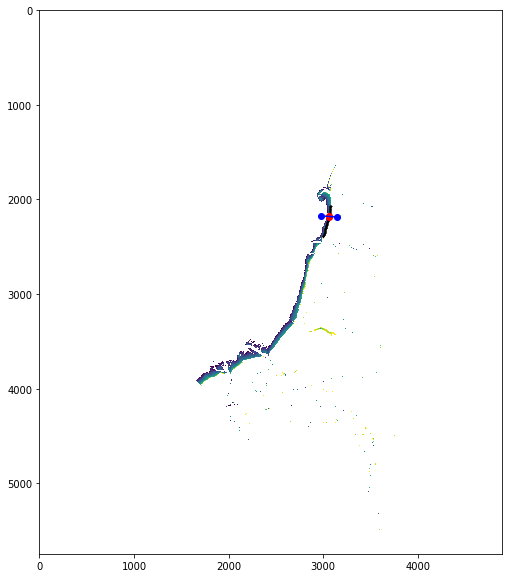

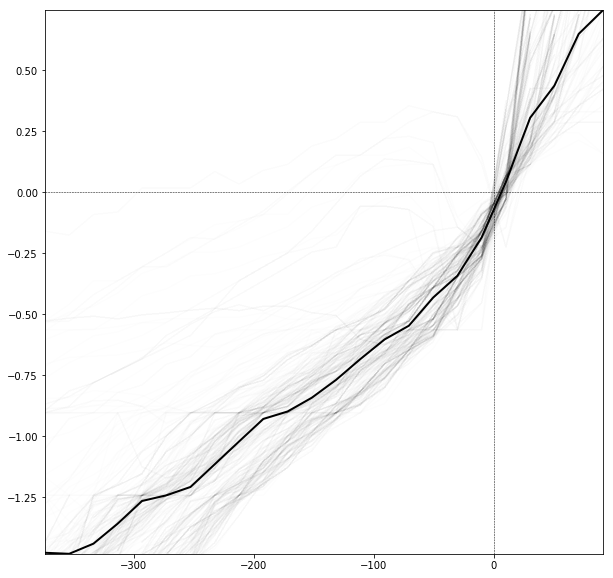

In [414]:

def perp_bisector(x0, x1, y0, y1, dist=0.5):
    
    """
    Source: https://math.stackexchange.com/questions/656500/given-a-
    point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    """
    
    # Compute midpoint
    y_mid = np.mean([y0, y1])
    x_mid = np.mean([x0, x1])

    # Compute slope and slope of perpendicular
    slope = (y1 - y0) / (x1 - x0)
    perp_slope = -1.0 / slope

    # Compute first point
    x2 = -dist * (1.0 / math.sqrt(1 + perp_slope**2)) + x_mid
    y2 = -dist * (perp_slope / math.sqrt(1 + perp_slope**2)) + y_mid
    
    # Compute second point
    x3 = dist * (1.0 / math.sqrt(1 + perp_slope**2)) + x_mid
    y3 = dist * (perp_slope / math.sqrt(1 + perp_slope**2)) + y_mid
    
    return (x2, y2), (x3, y3) 

# Import gdal layer
nidem_ds = gdal.Open('output_data/dem/NIDEM_dem_{}.tif'.format(136))
z = nidem_ds.GetRasterBand(1).ReadAsArray()

# Extract longest contour
contours = measure.find_contours(z, 0)
contours.sort(key=len, reverse=True)
longest_contour = contours[0]


y = longest_contour[:,0]
x = longest_contour[:,1]


elev_transects = list()

for i in range(1, 500):
    
    try:

        # Randomly select segment of contour
        rand_samp = random.randint(0,len(longest_contour))
        (y0,x0),(y1,x1) = longest_contour[np.array([rand_samp,rand_samp+2]),]
        (x2, y2), (x3, y3) = perp_bisector(x0=x0, x1=x1, y0=y0, y1=y1, dist=2000/25.0)

        # Extract elevation profile
        num = 100
        trans_x, trans_y = np.linspace(x2, x3, num), np.linspace(y2, y3, num)
        elev_transect = z[trans_y.astype("int"), trans_x.astype("int")] / 1000.0

        # Check order and rearrange if necessesary to keep low values at left
        if np.nanmean(elev_transect[0:50]) > np.nanmean(elev_transect[50:100]):
            elev_transect = elev_transect[::-1]

        elev_transects.append(elev_transect)
    
    except:
        None

stacked_transects = np.vstack(elev_transects)    
elev_transect_median = np.nanmedian(stacked_transects, axis = 0)  

# Number of valid transects by distance
count_transects = np.sum(~np.isnan(stacked_transects), axis = 0)
elev_transect_median[count_transects < 100] = np.nan 
distance_vals = np.linspace(-1000, 1000, num)[~np.isnan(elev_transect_median)]
    
# First plot
fig, axes = plt.subplots(figsize = (10, 10))
axes.set_aspect('equal')
axes.imshow(z)
axes.scatter(x, y, c = "black", s = 0.1)
axes.plot([x0, x1], [y0, y1], 'ro-')
axes.plot([x2, x3], [y2, y3], 'bo-')
plt.show()

# Second plot
fig, axes = plt.subplots(figsize = (10, 10))
for elev_transect in elev_transects:
    axes.plot(np.linspace(-1000, 1000, num), elev_transect, alpha = 0.008, c="black")
    
axes.plot(np.linspace(-1000, 1000, num), elev_transect_median, c="black", linewidth = 2)
axes.set_xlim(np.min(distance_vals), np.max(distance_vals))
axes.set_ylim(np.nanmin(elev_transect_median), np.nanmax(elev_transect_median))
axes.axhline(y = 0, color = 'k', linestyle = '--', lw = 0.5)
axes.axvline(x = 0, color = 'k', linestyle = '--', lw = 0.5)
plt.show()

## Test of 3D visualisation for ITEM

In [29]:
# Working directory
os.chdir("/g/data/r78/rt1527/nidem")

# Import DEA Notebooks scripts
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import SpatialTools 

# Define path to ITEM offset product
item_offset_path = '/g/data2/v10/ITEM/offset_products'
item_relative_path = '/g/data2/v10/ITEM/rel_products'
item_conf_path = '/g/data2/v10/ITEM/conf_products'

# Import raster and extract shape, projection info and geotransform data
polygon_ID = 135
item_filename = glob.glob("{}/ITEM_REL_{}_*.tif".format(item_relative_path, polygon_ID))[0]
item_ds = gdal.Open(item_filename)
item_array = item_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = item_array.shape
prj = item_ds.GetProjection()
geotrans = item_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Import raster and extract shape, projection info and geotransform data
nidem_filename = glob.glob("output_data/dem/NIDEM_dem_{}.tif".format(polygon_ID))[0]
nidem_ds = gdal.Open(nidem_filename)
nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 

# Reproject SRTM
srtm_reproj = SpatialTools.reproject_to_template(input_raster='/g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0',
                                                      template_raster=item_filename, 
                                                      output_raster="scratch/srtm_{}.tif".format(polygon_ID), 
                                                      resampling=gdal.GRA_Bilinear, nodata_val=np.nan) 
srtm_array = srtm_reproj.GetRasterBand(1).ReadAsArray()
srtm_array = srtm_array
srtm_array

# Fix uni
nidem_array = nidem_array / 100.0

# Assign values
nidem_array[item_array == 0] = np.nanmin(nidem_array) / 100
nidem_array[item_array == 9] = srtm_array[item_array == 9]



SpatialTools.array_to_geotiff(fname = "scratch/NIDEM_3D_srtm3.tif".format(polygon_ID), 
                              data = nidem_array, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = np.nan)






# # # Assign values
# # nidem_array[item_array == 0] = np.nanmin(nidem_array)
# # nidem_array[item_array == 9] = np.nanmax(nidem_array)
# # plt.imshow(nidem_array)

# # # Export resulting DEM as a geotiff
# # print("Exporting DEM for polygon {}".format(polygon_ID))
# # SpatialTools.array_to_geotiff(fname = "scratch/NIDEM_3d_{}.tif".format(polygon_ID), 
# #                               data = nidem_array, 
# #                               geo_transform = geotrans, 
# #                               projection = prj, 
# #                               nodata_val = np.nan)

# # # Reproject SRTM
# # srtm_reproj = SpatialTools.reproject_to_template(input_raster='/g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0',
# #                                                       template_raster=item_filename, 
# #                                                       output_raster="scratch/srtm_{}.tif".format(polygon_ID), 
# #                                                       resampling=gdal.GRA_Bilinear, nodata_val=-9999) 

# # srtm_array = srtm_reproj.GetRasterBand(1).ReadAsArray()
# # srtm_array = srtm_array

# # nidem_array[item_array == 9] = srtm_array[item_array == 9]

# SpatialTools.array_to_geotiff(fname = "scratch/NIDEM_3D_srtm.tif".format(polygon_ID), 
#                               data = srtm_array, 
#                               geo_transform = geotrans, 
#                               projection = prj, 
#                               nodata_val = np.nan)
# srtm_reproj = None

Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/srtm_135.tif


In [27]:
srtm_reproj = None


In [17]:
np.min(srtm_array)

-9999000.0

In [ ]:
def extract_contours():

    # Output dict to hold contours for each offset
    contour_dict = collections.OrderedDict()

    for contour_offset in contour_offsets:

        # Extract contours from array
        contours = skimage.measure.find_contours(offset_array, contour_offset)
        print('Extracting contour {}'.format(contour_offset))

        # Iterate through each contour feature, remove NAs and fix coordinates
        contour_list = list()
        for contour in contours:

            # Convert index coordinates to spatial coordinates in-place
            contour[:, 0] = contour[:, 0] * float(y_size) + upleft_y + (float(y_size) / 2)
            contour[:, 1] = contour[:, 1] * float(x_size) + upleft_x + (float(x_size) / 2)
            contour = np.insert(contour, 2, contour_offset, axis=1)

            # Remove contour points with NAs
            contour = contour[~np.isnan(contour).any(axis=1)]
            contour_list.append(contour)

        # Add list of contour arrays to dict
        contour_dict[contour_offset] = contour_list

    # Export contours to line shapefile to assist in evaluating DEMs
    schema = {'geometry':  'MultiLineString',
              'properties': {'elevation': 'float:9.2'}}

    with fiona.open('output_data/contour/NIDEM_contours_{}.shp'.format(polygon_id), 'w',
                    crs=from_epsg(3577),
                    driver='ESRI Shapefile',
                    schema=schema) as output:

        for elevation_value, contour_list in contour_dict.items():

            # Filter out contours with less than two points (i.e. non-lines)
            contour_list = [x for x in contour_list if len(x) > 1]

            # Create multiline string by first flipping coordinates then creating list of linestrings
            contour_linestrings = [LineString([(x, y) for (y, x, z) in contour_array])
                                   for contour_array in contour_list]
            contour_multilinestring = MultiLineString(contour_linestrings)

            # Write output shapefile to file with elevation field
            output.write({'properties': {'elevation': elevation_value},
                          'geometry': mapping(contour_multilinestring)})